In [55]:
import numpy as np
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from typing import List

class Input:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def __init__(self, inputFeatures) -> None:
		self.inputShape = (-1, inputFeatures)
		self.outputShape = self.inputShape

	def forward(self, x):
		return x

	def backward(self, gradientLossWRTOutput, _):
		return gradientLossWRTOutput, None


class DropOut:
	def __init__(self,dropProb):
		self.dropProb = dropProb

	def forward(self, x):
		self.mask = np.random.uniform(*x.shape) > self.dropProb
		return np.multiply(x, self.mask) / (1- self.dropProb)

	def backward(self,gradientLossWRTOutput, _):
		return np.multiply(self.mask, gradientLossWRTOutput) / (1 - self.dropProb), None

	def initPipeline(self,inputShape,name):
		self.inputShape = inputShape
		self.outputShape = inputShape
		self.name = name

class Dense:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #nodes)

	def __init__(self, numNodes) -> None:
		self.numNodes = numNodes

	# input shape: (batch_size, #features)
	def initPipeline(self, inputShape, name):
		inputFeatures = inputShape[1]
		self.features = inputFeatures
		self.name = name

		# self.weights = np.random.randn(self.numNodes, inputFeatures)
		a = .3
		a = np.sqrt(6 / (inputFeatures + self.numNodes))

		self.weights = np.random.uniform(-a, a, (self.numNodes, inputFeatures))

		# self.weights = np.ones((self.numNodes, inputFeatures))
		# print(self.weights.shape)
		# self.bias = np.random.randn(self.numNodes, 1)
		self.bias = np.random.uniform(-a, a, (self.numNodes, 1))

		# self.bias = np.ones((self.numNodes, 1))
		# print(self.bias.shape)
		self.outputShape = (-1, self.numNodes)

	# x shape: (batch_size, #features)
	def forward(self, x):
		self.x = x
		self.y = np.dot(self.weights, x.T) + self.bias
		self.y = self.y.T
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #nodes)

	def backward(self, gradientLossWRTOutput,optimizer):

		gradientLossWRTInput = np.dot(gradientLossWRTOutput, self.weights)


		gradientLossWRTWeights = np.dot(gradientLossWRTOutput.T, self.x)
		gradientLossWRTBias = np.sum(gradientLossWRTOutput, axis = 0, keepdims=True).T

		# print(f"gradientLossWRTWeights : {gradientLossWRTWeights.shape}")
		# print(f"gradientLossWRTbias : {gradientLossWRTBias.shape}")


		self.weights = optimizer.update(self.name + '-w', self.weights, gradientLossWRTWeights)
		self.bias = optimizer.update(self.name + '-b', self.bias, gradientLossWRTBias)

		# self.weights -= learningRate * gradientLossWRTWeights
		# self.bias -= learningRate * gradientLossWRTBias

		return gradientLossWRTInput, (gradientLossWRTWeights, gradientLossWRTBias)

	def getWeights(self):
		return (self.weights, self.bias)

	def addWeights(self, optimizer):
		optimizer.addWeight(self.name + '-w', self.weights)
		optimizer.addWeight(self.name + '-b', self.bias)


class Softmax:
	def __init__(self) -> None:
		pass

	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def initPipeline(self, inputShape, name):
		self.inputShape = inputShape
		self.outputShape = inputShape
		self.name = name

	def forward(self, x):
		self.x = x
		# print(self.x)
		# print(np.max(self.x))
		self.y =  np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)

	def backward(self, gradientLossWRTOutput, _):
		# gradientOutputWRT

		n , m = self.y.shape

		gradientOutputWRTInput = np.repeat(self.y, m, axis=0).reshape(n, m, m)
		gradientOutputWRTInput = np.multiply(gradientOutputWRTInput, np.transpose(gradientOutputWRTInput, axes=(0, 2, 1))) * -1

		diagElems = np.reshape(self.y, (n,  m , 1))
		diagElems = diagElems * (1 - diagElems)
		diagElems = np.eye(m) * diagElems
		mask = np.eye(m, dtype=bool)
		mask = np.tile(mask, (n, 1)).reshape(n, m, m)
		gradientOutputWRTInput[mask] = 0
		gradientOutputWRTInput = gradientOutputWRTInput + diagElems

		# jacobian_matrix = np.zeros((n, m, m))

		# for i in range(n):
		# 	# s = np.exp(self.x[i]) / np.sum(np.exp(self.x[i]), axis=1, keepdims=True)
		# 	s = self.y[i]
		# 	for j in range(n):
		# 		for k in range(n):
		# 			jacobian_matrix[i, j, k] = s[j] * (int(j == k) - s[k])


		# print(np.isclose(jacobian_matrix, gradientOutputWRTInput).all())
		# print(f"gradientLossWRTOutput : {np.expand_dims(gradientLossWRTOutput, -1).shape}")


		gradientLossWRTInput = np.matmul(gradientOutputWRTInput, np.expand_dims(gradientLossWRTOutput, -1))
		gradientLossWRTInput = np.squeeze(gradientLossWRTInput)

		# print(f"gradientLossWRTInput : {gradientLossWRTInput.shape}")

		return gradientLossWRTInput, None


class Relu:

	def __init__(self) -> None:
		pass

	def initPipeline(self, inputShape,name):
		self.inputShape = inputShape
		self.outputShape = inputShape
		self.name = name

	def forward(self, x):
		self.x = x
		self.y = np.maximum(x, 0)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)
	def backward(self, gradientLossWRTOutput, _):
		gradientOutputWRTInput = np.where(self.x > 0, 1, 0)
		gradientLossWRTInput = np.multiply(gradientOutputWRTInput, gradientLossWRTOutput)
		return gradientLossWRTInput, None



class Model:
	EPSILON = .000001
	def __init__(self, *layers) -> None:
		self.nLayers = len(layers)

		for i in range(1, self.nLayers):
			layers[i].initPipeline(layers[i-1].outputShape, f"layer-{i}")

		self.layers = layers

	def forward(self, x):
		for layer in self.layers:
			x = layer.forward(x)
		return x

	def predict(self, x):
		for layer in self.layers:
			if isinstance(layer, DropOut):
				continue
			x = layer.forward(x)
		return x

	def crossEntropyGradient(self, yTrue, yPred):
		ypc = yPred.copy()
		ypc[ypc < Model.EPSILON] = Model.EPSILON
		return - yTrue / ypc

	def __backprop(self,yTrue, yPred, optimizer):
		gradientLossWRTOutput = self.crossEntropyGradient(yTrue, yPred)
		# gradientLossWRTOutput = self.squaredErrorGradient(yTrue, yPred)
		# print(gradientLossWRTOutput)

		# print(f"loss grad wrt yhat : {gradientLossWRTOutput.shape}")
		# wAndg = []
		for layer in reversed(self.layers):
			gradientLossWRTOutput, g = layer.backward(gradientLossWRTOutput, optimizer)
			# wAndg.append((layer.getWeights(), g))


	def crossEntropyLoss(self, yPred, yTrue):
		ypc = yPred.copy()
		ypc[ypc < Model.EPSILON] = Model.EPSILON
		return -np.mean(yTrue * np.log(ypc))


		# return wAndg

	def train(self, x, y, optimizer, epoch, batchSize, perIterCallBack = None, perEpochCallBack = None):

		losses = []

		for layer in self.layers:
			if hasattr(layer, 'addWeights'):
				layer.addWeights(optimizer)


		for j in range(epoch):
			numExa = x.shape[0]

			xy = list(zip(x, y))
			np.random.shuffle(xy)

			x, y = zip(*xy)

			x = np.array(x)
			y = np.array(y)

			numExa = x.shape[0]
			numBatches = numExa // batchSize
			remSamples = numExa % batchSize



			xB = np.array_split(x[:numBatches * batchSize], numBatches)
			yB = np.array_split(y[:numBatches * batchSize], numBatches)

			if remSamples > 0:
				xB.append(x[-remSamples:])
				yB.append(y[-remSamples:])
				numBatches += 1

			for i in range(numBatches):
				xc = xB[i]
				yc = yB[i]

				yPred = self.forward(xc)
				self.__backprop(yc, yPred, optimizer)

				closs = self.crossEntropyLoss(yc, yPred)
				losses.append(closs)
				# print(f"loss : {closs}")
				# print(f"loss : {self.crossEntropyLoss(y, self.forward(x))}")

				if perIterCallBack != None:
					perIterCallBack(self)

			optimizer.reset()
			print(f"iteration {j + 1} complete")
			if perEpochCallBack != None:
				perEpochCallBack(self)

		return losses


	def squaredErrorGradient(self, yTrue, yPred):
		return -2 * (yTrue - yPred)




class GradientDescent:
	def __init__(self, learningRate) -> None:
		self.learningRate = learningRate

	def addWeight(self, layerName, weight):
		pass

	def update(self, layerName, w, g):
		return w - self.learningRate * g

	def reset(self):
		pass

class Adam:
	def __init__(self, learningRate, beta1 = .9, beta2 = .999, epsilon = 1e-6) -> None:
		self.learningRate = learningRate
		self.beta1 = beta1
		self.beta2 = beta2
		self.epsilon = epsilon
		self.vs = {}
		self.ss = {}
		self.t = 0

	def addWeight(self, layerName, weight):
		self.vs[layerName] = np.zeros_like(weight)
		self.ss[layerName] = np.zeros_like(weight)

	def update(self, layerName, w, g):
		self.t += 1
		v = self.vs[layerName]
		s = self.ss[layerName]
		v = self.beta1 * v + (1 - self.beta1) * g
		s = self.beta2 * s + (1 - self.beta2) * (g ** 2)
		vc = v / (1 - self.beta1 ** self.t)
		sc = s / (1 - self.beta2 ** self.t)
		self.vs[layerName] = v
		self.ss[layerName] = s

		return w - self.learningRate * vc / (np.sqrt(sc) + self.epsilon)



	def reset(self):
		for key in self.vs:
			self.vs[key] = np.zeros_like(self.vs[key])
			self.ss[key] = np.zeros_like(self.ss[key])
		self.t = 0

class Emnist:
	def __init__(self, path):
		self.train = ds.EMNIST(root = path, split = 'letters', train = True, transform = transforms.ToTensor(), download = True)
		self.test = ds.EMNIST(root = path, split = 'letters', train = False, transform = transforms.ToTensor(), download = True)

	def dataTrain(self):
		return self.train.data.numpy(), self.train.targets.numpy()

	def dataTest(self):
		return self.test.data.numpy(), self.test.targets.numpy()

def eqn(x):
	return 2 * (x[0] ** 2) + 3.5 * x[1] + 7


def oneHotEncode(yTr, yTs):
	encoder = OneHotEncoder(sparse_output=False)
	oneHotYtr = encoder.fit_transform(np.expand_dims(yTr, -1))
	oneHotYts = encoder.transform(np.expand_dims(yTs, -1))

	return oneHotYtr, oneHotYts

def normalize(x):
	return x / 255

def flatten(x):
	return np.reshape(x, (x.shape[0], -1))


def acc(model, x, yTrue):
	yPred = model.predict(x)
	yPred = np.argmax(yPred, axis = 1)
	yTrue = np.argmax(yTrue, axis = 1)
	return accuracy_score(yTrue, yPred)

def plot(loss1, loss2):
	plt.figure(figsize=(8, 5))
	plt.plot(loss1,  linestyle='-', color='green', label='Training')
	plt.plot(loss2, linestyle='-', color='red', label='Validation')
	plt.title('Training')
	plt.xlabel('Iterations')
	plt.ylabel('Loss')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def macroF1(model, x, yTrue):
	yPred = model.predict(x)
	yPred = np.argmax(yPred, axis = 1)
	yTrue = np.argmax(yTrue, axis = 1)
	return f1_score(yTrue, yPred, average='macro')

class Metrics:
  def __init__(self, name):
    self.tL = []
    self.vL = []
    self.tA = []
    self.vA = []
    self.vf1 = []
    self.name = name



In [76]:
def getSmallModel(numFeatures, output, dropoutRate = .25):
	model = Model(
			Input(numFeatures),
			Dense(32),
			DropOut(dropoutRate),
			Relu(),
			Dense(output),
			Softmax()
	)
	return model

def getMediumModel(numFeatures, output, dropoutRate = .25):
	model = Model(
			Input(numFeatures),
      Dense(128),
      DropOut(dropoutRate),
      Relu(),
      Dense(64),
      DropOut(dropoutRate),
      Relu(),
			Dense(32),
			DropOut(dropoutRate),
			Relu(),
			Dense(output),
			Softmax()
	)
	return model

def getLargeModel(numFeatures, output, dropoutRate = .25):
	model = Model(
			Input(numFeatures),
      Dense(1024),
      DropOut(dropoutRate),
      Relu(),
      Dense(256),
      DropOut(dropoutRate),
      Relu(),
      Dense(128),
      DropOut(dropoutRate),
      Relu(),
      Dense(64),
      DropOut(dropoutRate),
      Relu(),
			Dense(32),
			DropOut(dropoutRate),
			Relu(),
			Dense(output),
			Softmax()
	)
	return model



In [6]:
class Data:
  def __init__(self):
    self.tX = None
    self.tY = None
    self.vX = None
    self.vY = None
    self.tsX = None
    self.tsY = None

def prepareData():

  rt = Data()

  dataset = Emnist('/content/')
  trX, trY = dataset.dataTrain()
  tsX, tsY = dataset.dataTest()

  # print(trX.shape)

  trY, rt.tsY = oneHotEncode(trY, tsY)

  trX = normalize(trX)
  tsX = normalize(tsX)

  trX = flatten(trX)
  rt.tsX = flatten(tsX)


  rt.tX, rt.vX, rt.tY, rt.vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

  # print(tX.shape, tY.shape)
  # print(vX.shape, vY.shape)

  return rt


In [41]:
def trainModel(model, name, data, optimizer, epoch):

  batchSize = 256
  def perEpochCallBackWrapper(ld : Metrics):

    def perEpochCallBack(model):
      ld.tL.append(model.crossEntropyLoss(data.tY, model.predict(data.tX)))
      ld.vL.append(model.crossEntropyLoss(data.vY, model.predict(data.vX)))

      ld.tA.append(acc(model, data.tX, data.tY))
      ld.vA.append(acc(model, data.vX, data.vY))

      ld.vf1.append(macroF1(model, data.vX, data.vY))

    return perEpochCallBack


  metrics = Metrics(name)

  losses = model.train(data.tX, data.tY, optimizer, epoch, batchSize, perEpochCallBack = perEpochCallBackWrapper(smallModelMetrics))

  print(f"train accuracy : {acc(model, data.tX, data.tY)}")
  print(f"validation accuracy : {acc(model, data.vX, data.vY)}")
  print(f"test accuracy : {acc(model, data.tsX, data.tsY)}")

  return metrics


In [77]:
data = prepareData()
nFeatures = data.tX.shape[1]
outputs = data.tY.shape[1]

names = ['light', 'medium', 'heavy']
metrics = []
lrs = [.0005, .0001, .00005, .00001]
models = []

for lr in lrs:
  dropOutRate = .25
  modelsCurr = [getSmallModel(nFeatures, outputs, dropOutRate), getMediumModel(nFeatures, outputs, dropOutRate), getLargeModel(nFeatures, outputs, dropOutRate)]
  models.append(modelsCurr)

  for model, name in zip(modelsCurr, names):
    optimizer = Adam(lr)
    epoch = 25
    batchSize = 256

    def perEpochCallBackWrapper(ld : Metrics):
      def perEpochCallBack(model):
        ld.tL.append(model.crossEntropyLoss(data.tY, model.predict(data.tX)))
        ld.vL.append(model.crossEntropyLoss(data.vY, model.predict(data.vX)))

        ld.tA.append(acc(model, data.tX, data.tY))
        ld.vA.append(acc(model, data.vX, data.vY))

        ld.vf1.append(macroF1(model, data.vX, data.vY))

      return perEpochCallBack

    metric = Metrics(name)

    losses = model.train(data.tX, data.tY, optimizer, epoch, batchSize, perEpochCallBack = perEpochCallBackWrapper(metric))

    print(f"train accuracy : {acc(model, data.tX, data.tY)}")
    print(f"validation accuracy : {acc(model, data.vX, data.vY)}")
    print(f"test accuracy : {acc(model, data.tsX, data.tsY)}")
    metrics.append(metric)


iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete
iteration 6 complete
iteration 7 complete
iteration 8 complete
iteration 9 complete
iteration 10 complete
iteration 11 complete
iteration 12 complete
iteration 13 complete
iteration 14 complete
iteration 15 complete
iteration 16 complete
iteration 17 complete
iteration 18 complete
iteration 19 complete
iteration 20 complete
iteration 21 complete
iteration 22 complete
iteration 23 complete
iteration 24 complete
iteration 25 complete
train accuracy : 0.8472190799396682
validation accuracy : 0.8288995726495727
test accuracy : 0.8258653846153846
iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete
iteration 6 complete
iteration 7 complete
iteration 8 complete
iteration 9 complete
iteration 10 complete
iteration 11 complete
iteration 12 complete
iteration 13 complete
iteration 14 complete
iteration 15 complete
iteration 16 complete
iter

KeyboardInterrupt: ignored

In [69]:
len(metrics)

12

In [38]:

np.random.seed(13)

data = prepareData()
model = getSmallModel(data.tX.shape[1], data.tY.shape[1])

# optimizer = GradientDescent(.0001)
optimizer = Adam(.001)

epoch = 5
batchSize = 256

# print(tX.shape, tY.shape)

# vLosses = []
# tL = []
# vL = []
# tA = []
# vA = []
# vf1 = []

def perEpochCallBackWrapper(ld : Metrics):

  def perEpochCallBack(model):
    ld.tL.append(model.crossEntropyLoss(data.tY, model.predict(data.tX)))
    ld.vL.append(model.crossEntropyLoss(data.vY, model.predict(data.vX)))

    ld.tA.append(acc(model, data.tX, data.tY))
    ld.vA.append(acc(model, data.vX, data.vY))

    ld.vf1.append(macroF1(model, data.vX, data.vY))

  return perEpochCallBack


smallModelMetrics = Metrics("light")

losses = model.train(data.tX, data.tY, optimizer, epoch, batchSize, perEpochCallBack = perEpochCallBackWrapper(smallModelMetrics))

# plot(losses, vL)



print(f"train accuracy : {acc(model, data.tX, data.tY)}")
print(f"validation accuracy : {acc(model, data.vX, data.vY)}")
print(f"test accuracy : {acc(model, data.tsX, data.tsY)}")





iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete
train accuracy : 0.8093702865761689
validation accuracy : 0.7970085470085471
test accuracy : 0.7980769230769231


In [33]:
smallModelMetrics.vA

[0.7097756410256411,
 0.7490384615384615,
 0.7718482905982906,
 0.7874465811965812,
 0.7970085470085471]

In [72]:
def plotMetrics(metrics : List[Metrics], lr):
  fig, axes = plt.subplots(3, 2, figsize=(10, 10))
  axes = axes.flatten()

  def plot3(ax,arrs,legends,title):
    n = len(arrs)
    for i in range(n):
      ax.plot(arrs[i], label = legends[i])
      ax.set_title(title)
      ax.grid(True)
      ax.legend()
  tLs = []
  vLs = []
  tAs = []
  vAs = []
  vf1s = []
  legends = []

  for metric in metrics:
    tLs.append(metric.tL)
    vLs.append(metric.vL)
    tAs.append(metric.tA)
    vAs.append(metric.vA)
    vf1s.append(metric.vf1)
    legends.append(metric.name)


  plot3(axes[0], tLs, legends, 'Train Loss')
  plot3(axes[1], vLs, legends, 'Validation Loss')
  plot3(axes[2], tAs, legends, 'Train Accuracy')
  plot3(axes[3], vAs, legends, 'Validation Accuracy')
  plot3(axes[4], vf1s, legends, 'Validation f1')
  fig.delaxes(axes[5])

  plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
  plt.suptitle(f"Learning Rate = {lr}")




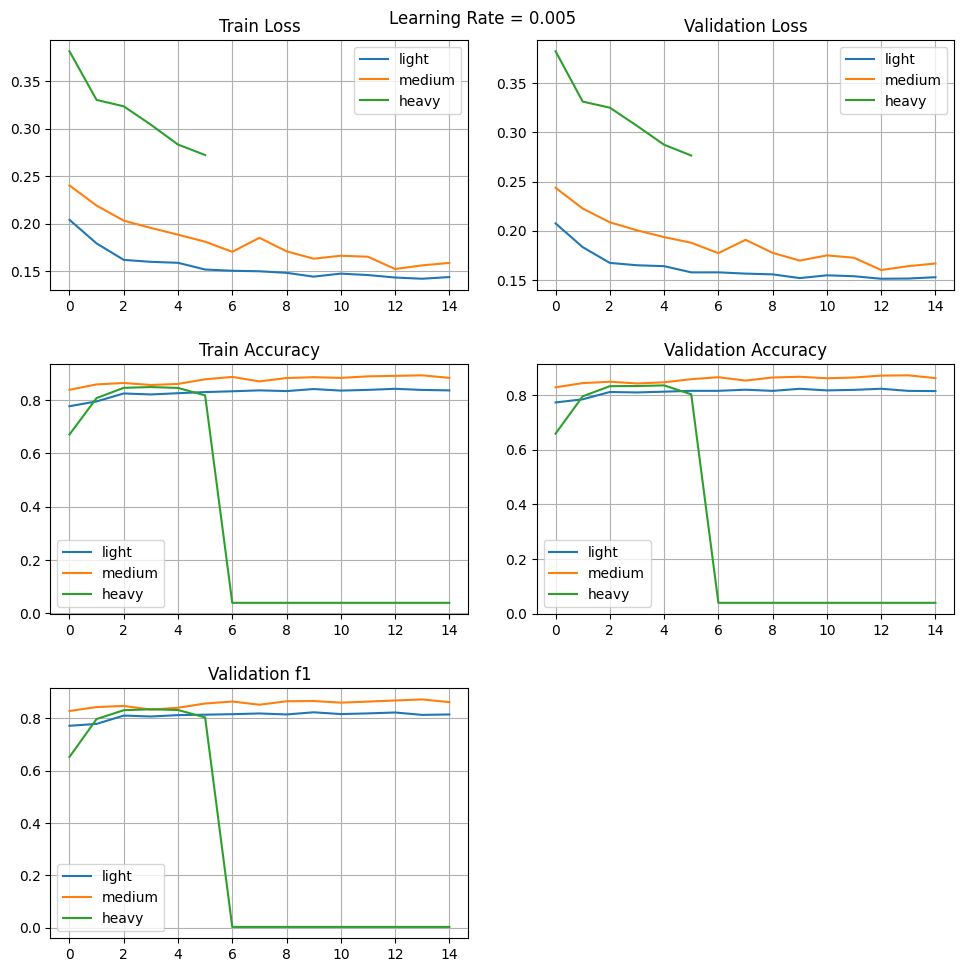

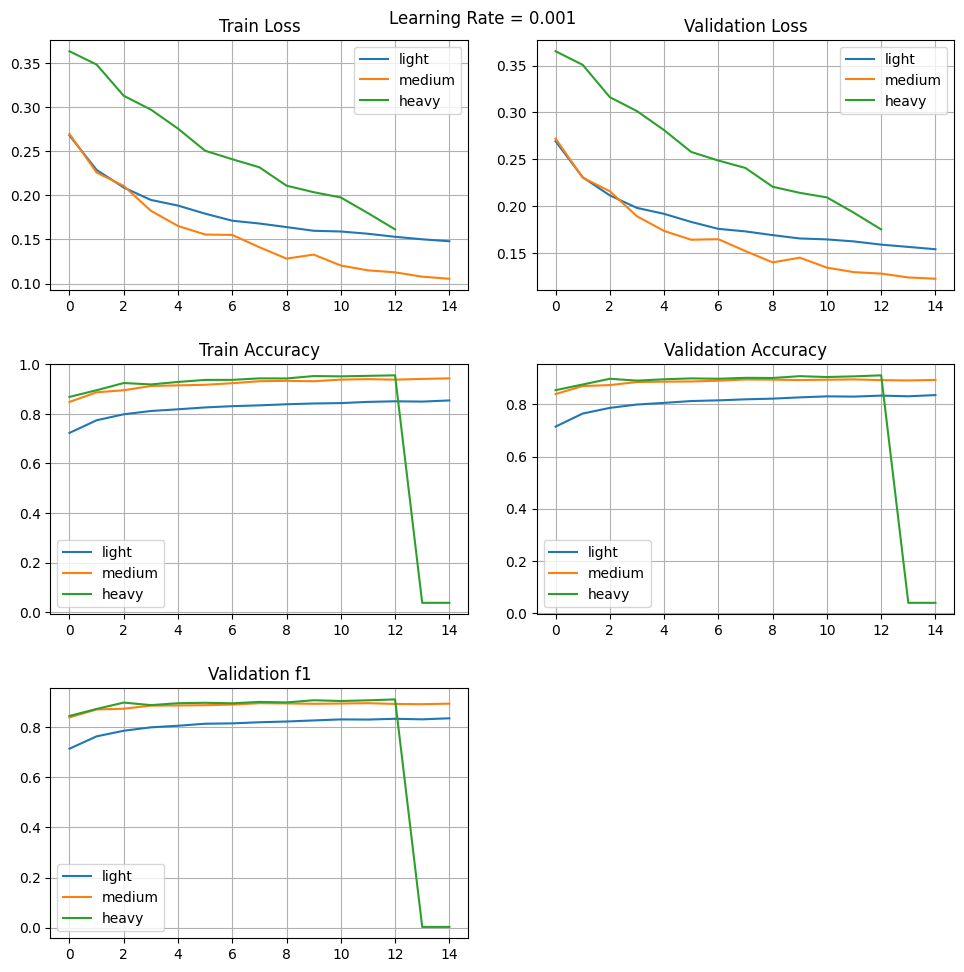

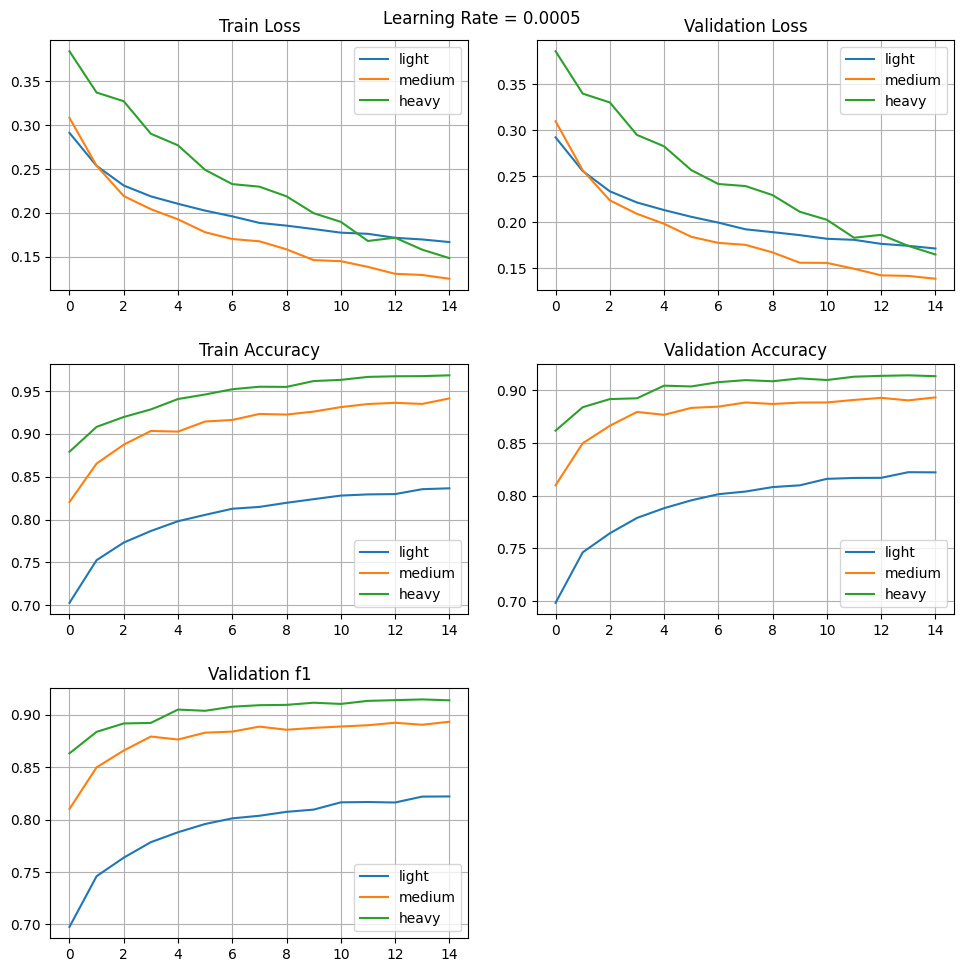

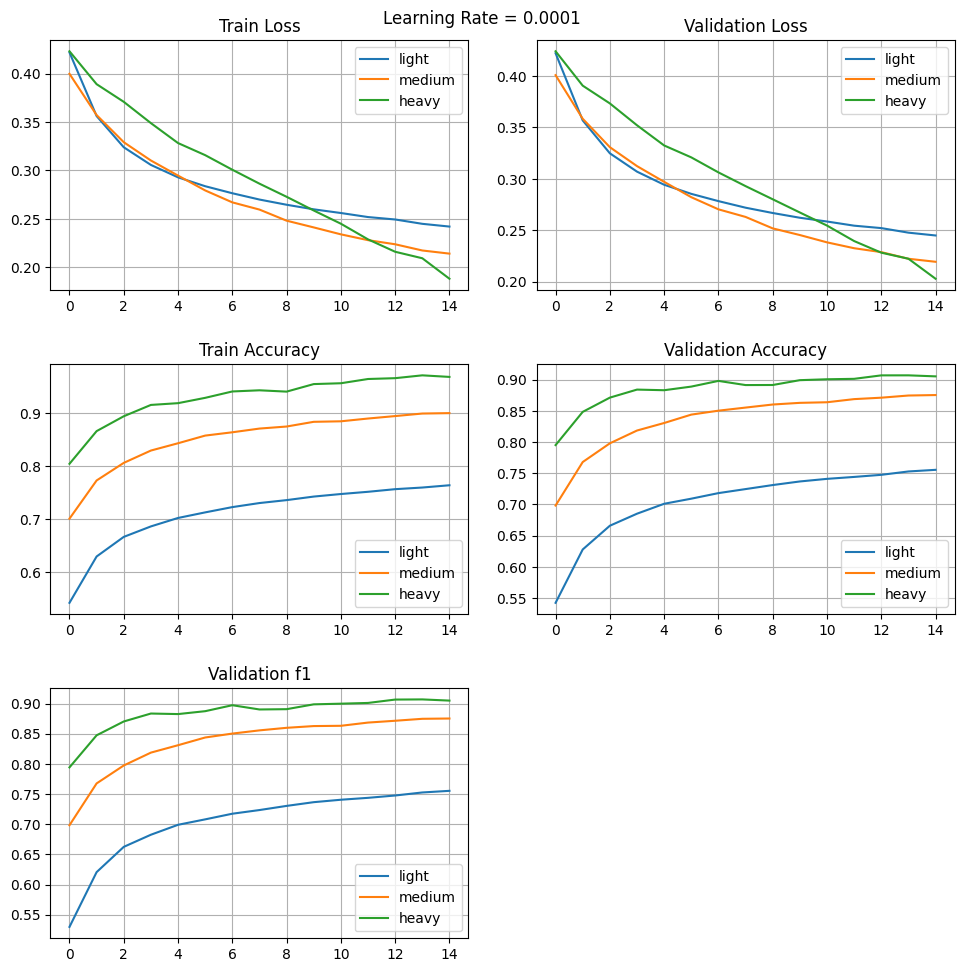

In [75]:
plotMetrics(metrics[0 : 3], .005)
plotMetrics(metrics[3 : 6], .001)
plotMetrics(metrics[6 : 9], .0005)
plotMetrics(metrics[9 : 12], .0001)


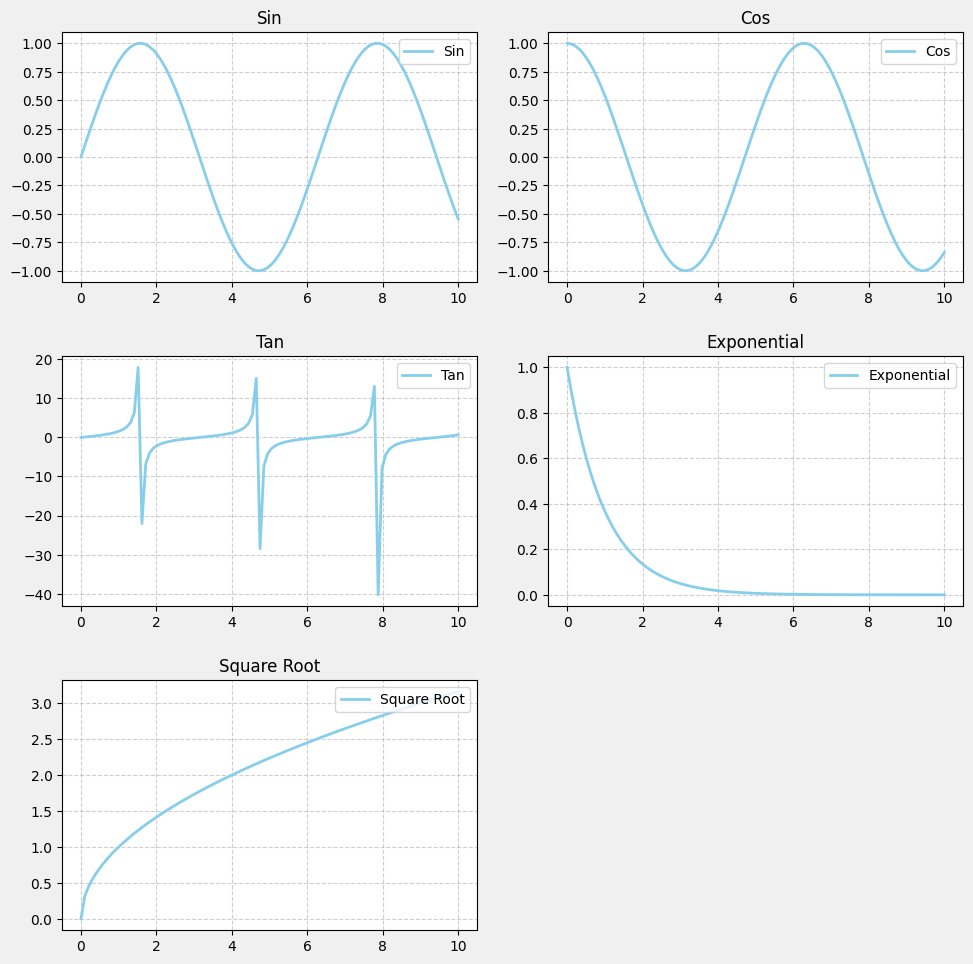

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Generating sample data for 5 arrays
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(-x)
y5 = np.sqrt(x)

# Creating subplots with a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Flattening the axes array
axes = axes.flatten()

# Plotting each array in a subplot with different styling and legends
plots = [y1, y2, y3, y4, y5]
titles = ['Sin', 'Cos', 'Tan', 'Exponential', 'Square Root']

for i, ax in enumerate(axes):
    if i < len(plots):
        line, = ax.plot(x, plots[i], label=titles[i], color='skyblue', linestyle='-', linewidth=2)
        ax.set_title(titles[i])
        ax.grid(True, linestyle='--', alpha=0.6)  # Adding gridlines
        ax.legend(handles=[line], loc='upper right')  # Adding legend

    else:
        fig.delaxes(ax)  # Remove unused subplots

# Adjust layout and spacing
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

# Set a background color for the entire plot
plt.gcf().set_facecolor('#f0f0f0')  # Light gray background color

plt.show()


#Moderate


(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete


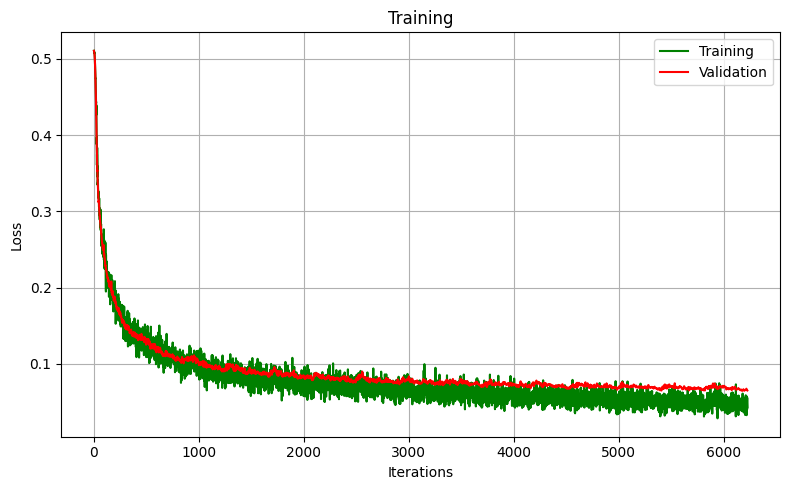

train accuracy : 0.9497643288084464
validation accuracy : 0.8986111111111111
test accuracy : 0.9015865384615385


In [ ]:
def getModel(numFeatures, output):
	model = Model(
			Input(numFeatures),
			Dense(128),
			DropOut(.25),
			Relu(),
			Dense(64),
			DropOut(.25),
			Relu(),
			Dense(32),
			DropOut(.25),
			Relu(),
			Dense(output),
			Softmax()
	)

	return model



def main():
	np.random.seed(13)
	dataset = Emnist('/content/')
	trX, trY = dataset.dataTrain()
	tsX, tsY = dataset.dataTest()

	# print(trX.shape)

	trY, tsY = oneHotEncode(trY, tsY)

	trX = normalize(trX)
	tsX = normalize(tsX)

	trX = flatten(trX)
	tsX = flatten(tsX)


	tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

	print(tX.shape, tY.shape)
	print(vX.shape, vY.shape)


	model = getModel(tX.shape[1], tY.shape[1])

	# optimizer = GradientDescent(.0001)
	optimizer = Adam(.001)

	epoch = 15
	batchSize = 256

	print(tX.shape, tY.shape)

	vLosses = []

	def callback(model):
		vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


	losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

	plot(losses, vLosses)



	print(f"train accuracy : {acc(model, tX, tY)}")
	print(f"validation accuracy : {acc(model, vX, vY)}")
	print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

# Complex

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete
iteration 6 complete
iteration 7 complete
iteration 8 complete
iteration 9 complete
iteration 10 complete
iteration 11 complete


<ipython-input-3-7d5e129214c8>:123: RuntimeWarning: invalid value encountered in divide
  self.y =  np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


iteration 12 complete
iteration 13 complete
iteration 14 complete
iteration 15 complete


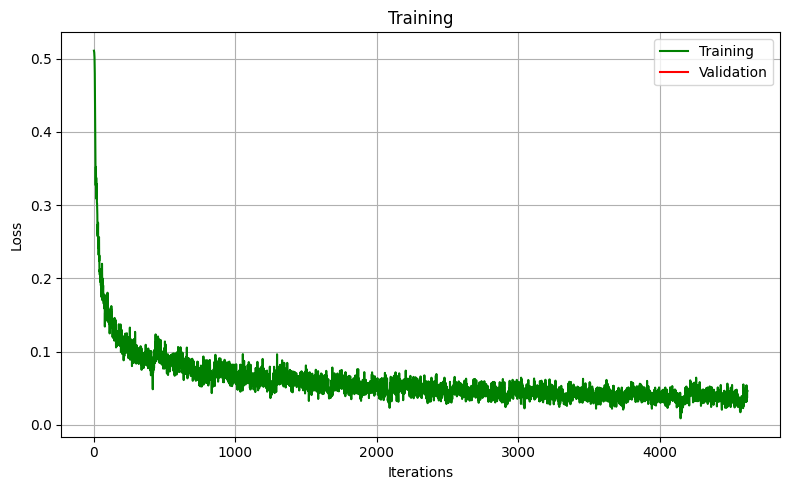

train accuracy : 0.03823529411764706
validation accuracy : 0.03974358974358974
test accuracy : 0.038461538461538464


In [ ]:

def getModel(numFeatures, output):
  model = Model(
      Input(numFeatures),
      Dense(1024),
      DropOut(.25),
      Relu(),
      Dense(512),
      DropOut(.25),
      Relu(),
      Dense(256),
      DropOut(.25),
      Relu(),
      Dense(128),
      DropOut(.25),
      Relu(),
      Dense(output),
      Softmax()
  )

  return model


def main():
  np.random.seed(13)

  dataset = Emnist('/content/')
  trX, trY = dataset.dataTrain()
  tsX, tsY = dataset.dataTest()

  # print(trX.shape)

  trY, tsY = oneHotEncode(trY, tsY)

  trX = normalize(trX)
  tsX = normalize(tsX)

  trX = flatten(trX)
  tsX = flatten(tsX)


  tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

  print(tX.shape, tY.shape)
  print(vX.shape, vY.shape)


  model = getModel(tX.shape[1], tY.shape[1])

  # optimizer = GradientDescent(.0001)
  optimizer = Adam(.001)

  epoch = 15
  batchSize = 256

  print(tX.shape, tY.shape)

  vLosses = []

  def callback(model):
    pass
    # vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


  losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

  plot(losses, vLosses)



  print(f"train accuracy : {acc(model, tX, tY)}")
  print(f"validation accuracy : {acc(model, vX, vY)}")
  print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete
iteration 6 complete
iteration 7 complete
iteration 8 complete
iteration 10 complete
iteration 11 complete
iteration 12 complete
iteration 13 complete
iteration 14 complete
iteration 15 complete


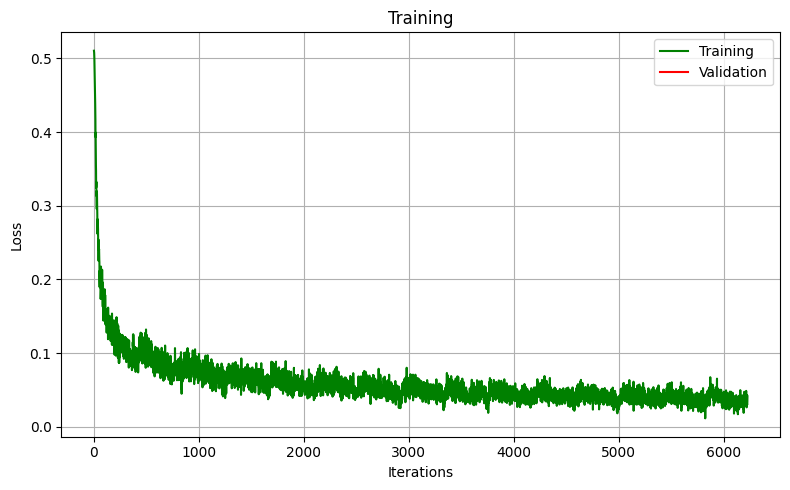

train accuracy : 0.9584464555052791
validation accuracy : 0.9075854700854701
test accuracy : 0.911201923076923


In [ ]:

def getModel(numFeatures, output):
  model = Model(
      Input(numFeatures),
      Dense(1024),
      DropOut(.25),
      Relu(),
      Dense(256),
      DropOut(.25),
      Relu(),
      Dense(128),
      DropOut(.25),
      Relu(),
      Dense(64),
      DropOut(.25),
      Relu(),
      Dense(32),
      DropOut(.25),
      Relu(),
      Dense(output),
      Softmax()
  )

  return model


def main():
  np.random.seed(13)
  dataset = Emnist('/content/')
  trX, trY = dataset.dataTrain()
  tsX, tsY = dataset.dataTest()

  # print(trX.shape)

  trY, tsY = oneHotEncode(trY, tsY)

  trX = normalize(trX)
  tsX = normalize(tsX)

  trX = flatten(trX)
  tsX = flatten(tsX)


  tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

  print(tX.shape, tY.shape)
  print(vX.shape, vY.shape)


  model = getModel(tX.shape[1], tY.shape[1])

  # optimizer = GradientDescent(.0001)
  optimizer = Adam(.001)

  epoch = 15
  batchSize = 256

  print(tX.shape, tY.shape)

  vLosses = []

  def callback(model):
    pass
    # vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


  losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

  plot(losses, vLosses)



  print(f"train accuracy : {acc(model, tX, tY)}")
  print(f"validation accuracy : {acc(model, vX, vY)}")
  print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete
iteration 6 complete
iteration 7 complete
iteration 8 complete
iteration 9 complete
iteration 10 complete
iteration 11 complete
iteration 12 complete
iteration 13 complete
iteration 14 complete
iteration 15 complete


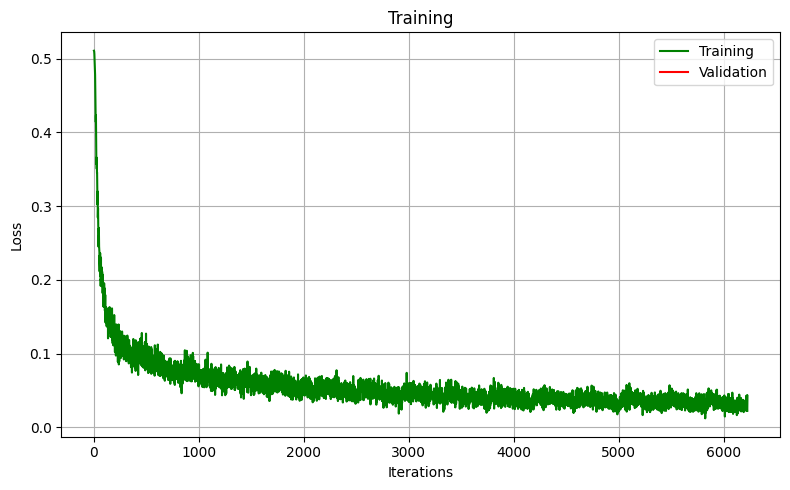

train accuracy : 0.9691930618401207
validation accuracy : 0.9144230769230769
test accuracy : 0.9171634615384615


In [ ]:

def getModel(numFeatures, output):
  model = Model(
      Input(numFeatures),
      Dense(1024),
      DropOut(.25),
      Relu(),
      Dense(256),
      DropOut(.25),
      Relu(),
      Dense(128),
      DropOut(.25),
      Relu(),
      Dense(64),
      DropOut(.25),
      Relu(),
      Dense(32),
      DropOut(.25),
      Relu(),
      Dense(output),
      Softmax()
  )

  return model


def main():
  np.random.seed(13)
  dataset = Emnist('/content/')
  trX, trY = dataset.dataTrain()
  tsX, tsY = dataset.dataTest()

  # print(trX.shape)

  trY, tsY = oneHotEncode(trY, tsY)

  trX = normalize(trX)
  tsX = normalize(tsX)

  trX = flatten(trX)
  tsX = flatten(tsX)


  tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

  print(tX.shape, tY.shape)
  print(vX.shape, vY.shape)


  model = getModel(tX.shape[1], tY.shape[1])

  # optimizer = GradientDescent(.0001)
  optimizer = Adam(.001)

  epoch = 15
  batchSize = 256

  print(tX.shape, tY.shape)

  vLosses = []

  def callback(model):
    pass
    # vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


  losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

  plot(losses, vLosses)



  print(f"train accuracy : {acc(model, tX, tY)}")
  print(f"validation accuracy : {acc(model, vX, vY)}")
  print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete
iteration 6 complete
iteration 7 complete
iteration 8 complete
iteration 9 complete
iteration 10 complete
iteration 11 complete
iteration 12 complete
iteration 13 complete
iteration 14 complete
iteration 15 complete


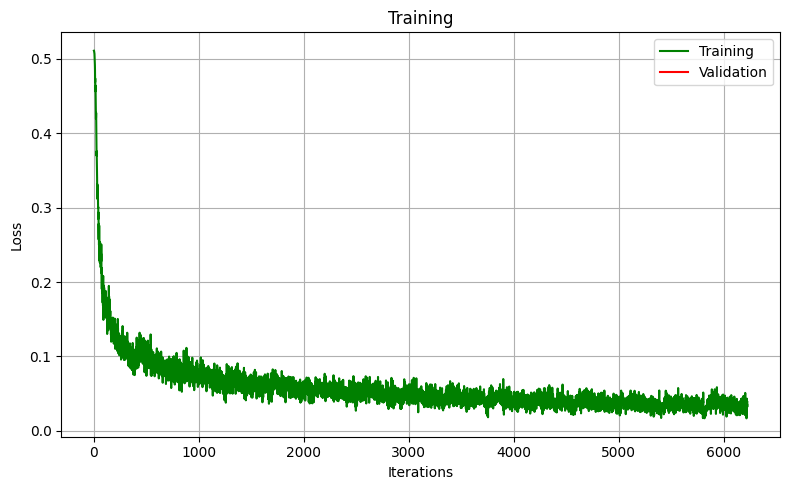

train accuracy : 0.9652432126696833
validation accuracy : 0.9138888888888889
test accuracy : 0.9155288461538461


In [ ]:

def getModel(numFeatures, output):
  model = Model(
      Input(numFeatures),
      Dense(512),
      DropOut(.65),
      Relu(),
      Dense(256),
      DropOut(.65),
      Relu(),
      Dense(128),
      DropOut(.65),
      Relu(),
      Dense(64),
      DropOut(.65),
      Relu(),
      Dense(32),
      DropOut(.65),
      Relu(),
      Dense(output),
      Softmax()
  )

  return model


def main():
  np.random.seed(13)
  dataset = Emnist('/content/')
  trX, trY = dataset.dataTrain()
  tsX, tsY = dataset.dataTest()

  # print(trX.shape)

  trY, tsY = oneHotEncode(trY, tsY)

  trX = normalize(trX)
  tsX = normalize(tsX)

  trX = flatten(trX)
  tsX = flatten(tsX)


  tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

  print(tX.shape, tY.shape)
  print(vX.shape, vY.shape)


  model = getModel(tX.shape[1], tY.shape[1])

  # optimizer = GradientDescent(.0001)
  optimizer = Adam(.001)

  epoch = 15
  batchSize = 256

  print(tX.shape, tY.shape)

  vLosses = []

  def callback(model):
    pass
    # vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


  losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

  plot(losses, vLosses)



  print(f"train accuracy : {acc(model, tX, tY)}")
  print(f"validation accuracy : {acc(model, vX, vY)}")
  print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete


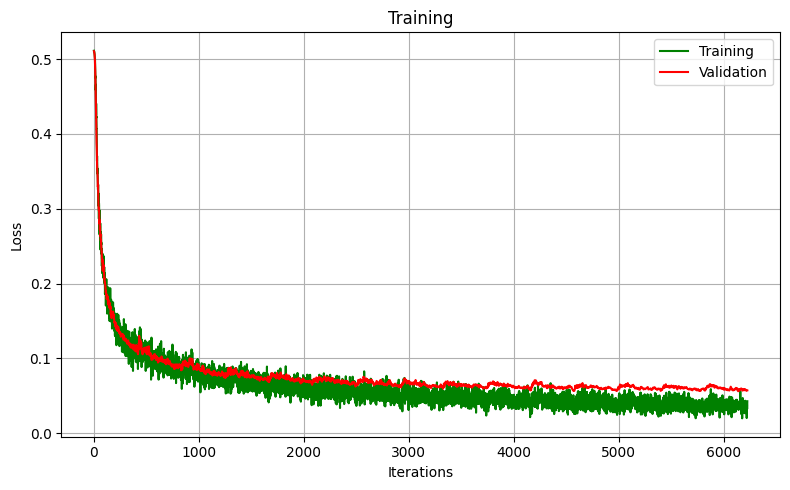

train accuracy : 0.9625471342383107
validation accuracy : 0.9066773504273504
test accuracy : 0.9099519230769231


In [ ]:

def getModel(numFeatures, output):
	model = Model(
			Input(numFeatures),
			Dense(256),
   		DropOut(.25),
			Relu(),
			Dense(128),
			DropOut(.25),
			Relu(),
			Dense(64),
			DropOut(.25),
			Relu(),
			Dense(32),
			DropOut(.25),
			Relu(),
			Dense(output),
			Softmax()
	)

	return model


def main():
	np.random.seed(13)
	dataset = Emnist('/content/')
	trX, trY = dataset.dataTrain()
	tsX, tsY = dataset.dataTest()

	# print(trX.shape)

	trY, tsY = oneHotEncode(trY, tsY)

	trX = normalize(trX)
	tsX = normalize(tsX)

	trX = flatten(trX)
	tsX = flatten(tsX)


	tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

	print(tX.shape, tY.shape)
	print(vX.shape, vY.shape)


	model = getModel(tX.shape[1], tY.shape[1])

	# optimizer = GradientDescent(.0001)
	optimizer = Adam(.001)

	epoch = 15
	batchSize = 256

	print(tX.shape, tY.shape)

	vLosses = []

	def callback(model):
		vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


	losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

	plot(losses, vLosses)



	print(f"train accuracy : {acc(model, tX, tY)}")
	print(f"validation accuracy : {acc(model, vX, vY)}")
	print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete
iteration 415 complete


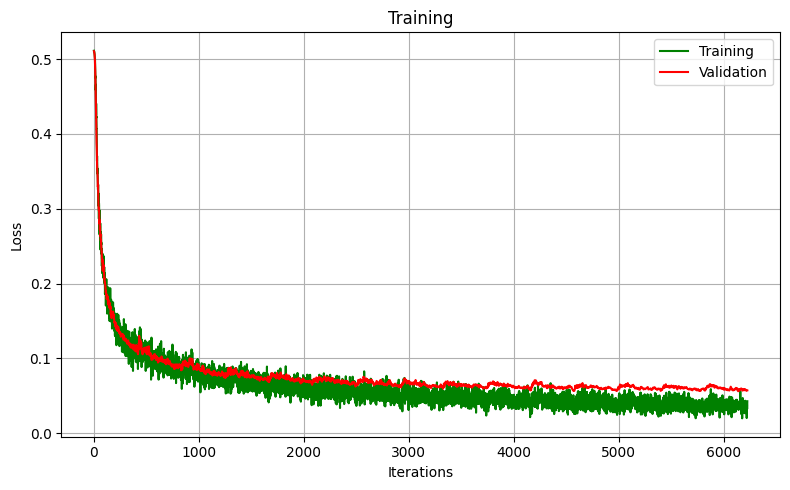

train accuracy : 0.9625471342383107
validation accuracy : 0.9066773504273504
test accuracy : 0.9099519230769231


In [ ]:

def getModel(numFeatures, output):
	model = Model(
			Input(numFeatures),
			Dense(256),
   		DropOut(.35),
			Relu(),
			Dense(128),
			DropOut(.35),
			Relu(),
			Dense(64),
			DropOut(.25),
			Relu(),
			Dense(32),
			DropOut(.15),
			Relu(),
			Dense(output),
			Softmax()
	)

	return model

def main():
	np.random.seed(13)
	dataset = Emnist('/content/')
	trX, trY = dataset.dataTrain()
	tsX, tsY = dataset.dataTest()

	# print(trX.shape)

	trY, tsY = oneHotEncode(trY, tsY)

	trX = normalize(trX)
	tsX = normalize(tsX)

	trX = flatten(trX)
	tsX = flatten(tsX)


	tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

	print(tX.shape, tY.shape)
	print(vX.shape, vY.shape)


	model = getModel(tX.shape[1], tY.shape[1])

	# optimizer = GradientDescent(.0001)
	optimizer = Adam(.001)

	epoch = 15
	batchSize = 256

	print(tX.shape, tY.shape)

	vLosses = []

	def callback(model):
		vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


	losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

	plot(losses, vLosses)



	print(f"train accuracy : {acc(model, tX, tY)}")
	print(f"validation accuracy : {acc(model, vX, vY)}")
	print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

# Simple

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
iteration 1 complete
iteration 2 complete
iteration 3 complete
iteration 4 complete
iteration 5 complete


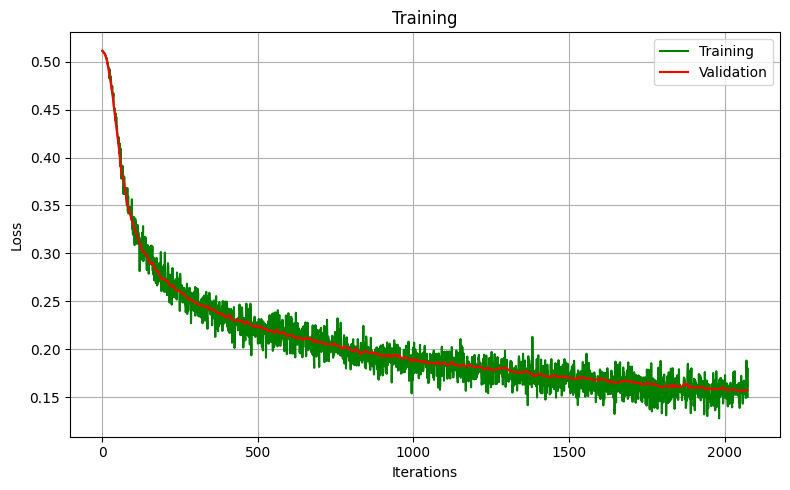

train accuracy : 0.8199566365007541
validation accuracy : 0.8081730769230769
test accuracy : 0.8067307692307693


In [ ]:
def getModel(numFeatures, output):
	model = Model(
			Input(numFeatures),
			Dense(32),
			DropOut(.25),
			Relu(),
			Dense(output),
			Softmax()
	)

	return model

def main():
	np.random.seed(13)
	dataset = Emnist('/content/')
	trX, trY = dataset.dataTrain()
	tsX, tsY = dataset.dataTest()

	# print(trX.shape)

	trY, tsY = oneHotEncode(trY, tsY)

	trX = normalize(trX)
	tsX = normalize(tsX)

	trX = flatten(trX)
	tsX = flatten(tsX)


	tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

	print(tX.shape, tY.shape)
	print(vX.shape, vY.shape)


	model = getModel(tX.shape[1], tY.shape[1])

	# optimizer = GradientDescent(.0001)
	optimizer = Adam(.001)

	epoch = 5
	batchSize = 256

	print(tX.shape, tY.shape)

	vLosses = []

	def callback(model):
		vLosses.append(model.crossEntropyLoss(vY,model.predict(vX)))


	losses = model.train(tX, tY, optimizer, epoch, batchSize, callback)

	plot(losses, vLosses)



	print(f"train accuracy : {acc(model, tX, tY)}")
	print(f"validation accuracy : {acc(model, vX, vY)}")
	print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

In [ ]:
train = ds.EMNIST(root = '/content/', split = 'letters', train = True, transform = transforms.ToTensor(), download = True)
test = ds.EMNIST(root = '/content/', split = 'letters', train = False, transform = transforms.ToTensor(), download = True)

In [ ]:
def randomPlot(x, y):
  num_images = x.shape[0]
  indices = np.random.choice(num_images, 16, replace=False)

  # Plotting 16 random images
  plt.figure(figsize=(8, 8))
  for i, index in enumerate(indices, 1):
      plt.subplot(4, 4, i)
      plt.imshow(x[index], cmap='gray')
      plt.title(f"{chr(np.argmax(y[index]) + ord('a') )}", fontsize=10)
      plt.axis('off')

  plt.tight_layout()
  plt.show()

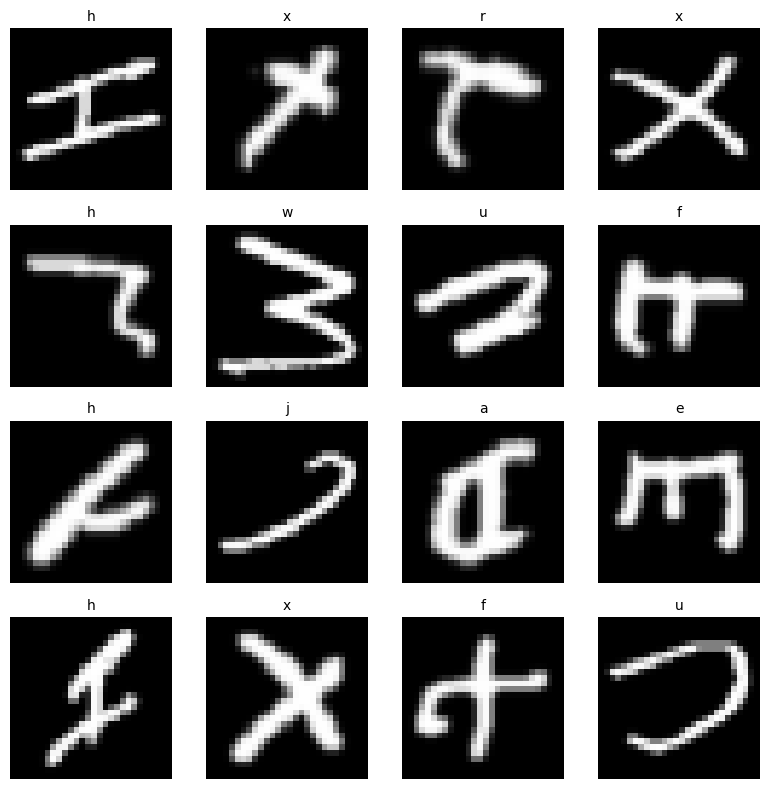

In [ ]:
randomPlot(tX, tY)